In [1]:
#! python 3.8

# Innovationsprojekt CAS AI

## Entwicklung des PRI-Anteils pro Sortierstandort und Wochentag
> Felix Businger & Fabienne Hadorn

**Ausgangslage**

Bereits heute ist sichtbar, dass sich die Nachfrage nach kürzeren Zustellzeiten und somit der Anteil an Prio-Paketen (Zustellung 1 Tag nach Aufgabe) bei der Schweizerischen Post verstärkt. 
Die Sortierung der Prio Pakete in den verschiedenen Sortierzentren erfolgt in einem kurzen Zeitfenster und die Kapazität wird mit stark wachsenden Mengen immer knapper. Daher ist es für die Planung wichtig zu wissen, wie viele Pakete mit welcher Laufzeit pro Tag erwartet werden können, um darauf basierenden Massnahmen zu definieren. 






# Data Preparation

### Load Packages

In [1]:
#pip install sktime

In [2]:
#pip install holidays

In [3]:
from datetime import date
import holidays

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#pip install pmdarima

In [5]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
#pip install Cython

### Load data of full years 2019 & 2020 and 2021 til November

In [7]:
df = pd.read_csv('.\Daten\Anteil_PRI_pro_Tag_2019-2021.csv', sep=',')
df.head(3)

,Datum,Produkt,PZ_plzzz,Sortiermenge,Tagesmenge,Anteil_PRI,Jahr,Monat_zahl,Monat,KW,KWJahr,Wochentag,Wochentag_nr
0,2019-01-02,PRI,131000,8660,44728,0.193615,2019,1,Jan,1,2019,Mittwoch,2
1,2019-01-02,PRI,400070,6509,6784,0.959463,2019,1,Jan,1,2019,Mittwoch,2
2,2019-01-02,PRI,462000,103928,209329,0.496482,2019,1,Jan,1,2019,Mittwoch,2


In [8]:
df.shape

(25984, 13)

Beschreibung der Attribute:
- Datum: Ist hier Sortiertag (auch Posttag) gemeint. Ein Posttag dauert von 04 Uhr bis 04 Uhr am Folgetag
- Produkt: sollte hier nur PRI enthalten
- PZ_plzzz: Sortierstandort, definiert über die 6-stellige PLZ
- Sortiermenge: ist die Anzahl PRI Pakete pro Sortiertag und Standort
- Tagesmenge: Gesamte Menge die an einem Sortiertag und einem Standort sortiert wurde. Inkludiert sind ECO-Pakete und restliche Mengen (also auch Sperrgut, Sameday, SEM etc.)
- Anteil PRI = Sortiermenge/Tagesmenge
- Monat_zahl = Monat (1-12)
- Monat = Monat als str abgekürzt (DE)
- KW: Kalenderwoche nach ISO
- KWJahr: Das Jahr zu welchem die Kalenderwoche gezählt wird. - in diesem Fall ist die Info nicht nützlich.
- Wochentag: ausgeschrieben (DE)
- Wochentag_nr = Wochentag als Zahl (0-6)

In [9]:
# Überprüfe ob nur PRI enthalten sind
df['Produkt'].unique()

array(['PRI'], dtype=object)

In [10]:
df.describe()

,Sortiermenge,Tagesmenge,Anteil_PRI,Jahr,Monat_zahl,KW,KWJahr,Wochentag_nr
count,25984.000000,25984.000000,25984.000000,25984.000000,25984.000000,25984.000000,25984.000000,25984.000000
mean,18235.304341,31596.263046,0.822249,2020.114878,6.539216,26.736222,2020.115148,2.271590
std,45847.230180,80579.707281,0.227516,0.804724,3.303539,14.439631,0.803177,1.673826
min,1.000000,1.000000,0.000036,2019.000000,1.000000,1.000000,2019.000000,0.000000
25%,105.000000,116.000000,0.606031,2019.000000,4.000000,14.000000,2019.000000,1.000000
50%,297.000000,329.000000,0.960966,2020.000000,7.000000,27.000000,2020.000000,2.000000
75%,7521.500000,8739.500000,0.987360,2021.000000,9.000000,39.000000,2021.000000,4.000000
max,333706.000000,512183.000000,1.000000,2021.000000,12.000000,53.000000,2021.000000,6.000000


Da an den Wochenenden in der Regel nicht sortiert wird, wollen wir nur MO-FR betrachten. 

In [11]:
df = df[df['Wochentag_nr']<5]

In [12]:
df.describe()

,Sortiermenge,Tagesmenge,Anteil_PRI,Jahr,Monat_zahl,KW,KWJahr,Wochentag_nr
count,23993.000000,23993.000000,23993.000000,23993.000000,23993.000000,23993.000000,23993.000000,23993.000000
mean,19663.350311,33913.119368,0.838099,2020.066519,6.514650,26.616013,2020.067978,1.991664
std,47401.275793,83245.354018,0.208152,0.804804,3.290553,14.379980,0.803775,1.411563
min,1.000000,1.000000,0.001140,2019.000000,1.000000,1.000000,2019.000000,0.000000
25%,119.000000,126.000000,0.622939,2019.000000,4.000000,14.000000,2019.000000,1.000000
50%,335.000000,354.000000,0.962963,2020.000000,7.000000,27.000000,2020.000000,2.000000
75%,8675.000000,9993.000000,0.987013,2021.000000,9.000000,39.000000,2021.000000,3.000000
max,333706.000000,512183.000000,1.000000,2021.000000,12.000000,53.000000,2021.000000,4.000000


In [13]:
#Renaming
df.rename(columns={'Sortiermenge':'PRI-Menge'}, inplace=True)
df.dtypes

Datum            object
Produkt          object
PZ_plzzz         object
PRI-Menge         int64
Tagesmenge        int64
Anteil_PRI      float64
Jahr              int64
Monat_zahl        int64
Monat            object
KW                int64
KWJahr            int64
Wochentag        object
Wochentag_nr      int64
dtype: object

In [14]:
# Datum in datetime ändern
df['Datum'] = pd.to_datetime(df['Datum'],errors='coerce')
df.dtypes

Datum           datetime64[ns]
Produkt                 object
PZ_plzzz                object
PRI-Menge                int64
Tagesmenge               int64
Anteil_PRI             float64
Jahr                     int64
Monat_zahl               int64
Monat                   object
KW                       int64
KWJahr                   int64
Wochentag               object
Wochentag_nr             int64
dtype: object

In [15]:
# Wo ist PRI-Anteil = 1
df[(df['Anteil_PRI']==1)
  &(df['Tagesmenge']>1000)][:10]

,Datum,Produkt,PZ_plzzz,PRI-Menge,Tagesmenge,Anteil_PRI,Jahr,Monat_zahl,Monat,KW,KWJahr,Wochentag,Wochentag_nr
12198,2020-08-12,PRI,130050,6820,6820,1.0,2020,8,Aug,33,2020,Mittwoch,2
12316,2020-08-17,PRI,130050,3095,3095,1.0,2020,8,Aug,34,2020,Montag,0
12353,2020-08-18,PRI,130050,3436,3436,1.0,2020,8,Aug,34,2020,Dienstag,1
12456,2020-08-21,PRI,130050,1567,1567,1.0,2020,8,Aug,34,2020,Freitag,4
12509,2020-08-24,PRI,130050,1607,1607,1.0,2020,8,Aug,35,2020,Montag,0
12647,2020-08-28,PRI,130050,2210,2210,1.0,2020,8,Aug,35,2020,Freitag,4
12698,2020-08-31,PRI,130050,1302,1302,1.0,2020,8,Aug,36,2020,Montag,0
13126,2020-09-16,PRI,130050,5061,5061,1.0,2020,9,Sep,38,2020,Mittwoch,2
13159,2020-09-17,PRI,130050,5935,5935,1.0,2020,9,Sep,38,2020,Donnerstag,3
13192,2020-09-18,PRI,130050,2290,2290,1.0,2020,9,Sep,38,2020,Freitag,4


Der Standort 130050 ist ein Briefzentrum. Dort werden zur Entlastung der Paketzentren Kleinpakete sortiert. Je nach Kunden, die direkt dort aufliefern, kann es gut möglich sein, dass nur PRI-Pakete sortiert werden

In [16]:
# Standort Bereinigung
df['PZ_plzzz'].value_counts().sort_values(ascending = True)[:20]

201307    1
400060    1
120007    1
342800    1
280000    1
197050    1
492270    1
807010    1
886770    1
107160    1
920068    2
659067    2
340040    2
601067    3
852070    3
832500    3
834300    3
659050    6
120067    7
818300    7
Name: PZ_plzzz, dtype: int64

- Der Standort 402100 ist ein neues Sortierzentrum, welches im September 2021 in Betrieb genommen wurde
    alle Standorte mit weniger Menge können wir ausschliessen
- Standorte die mit '70' enden, sind meistens Filialen, die hier nicht von Bedeutung sind. 
- Standorte, die mit '67' enden, sind meisten Annahmestellen in den Briefstandorten - auch diese sind hier nicht von Bedeutung

In [17]:
df_counts = df.groupby(['PZ_plzzz'], as_index=False)['Datum'].count()
df_counts.rename(columns={'Datum':'Anzahl'}, inplace=True)
df = pd.merge(df, df_counts, how='left', on='PZ_plzzz')
df.head(5)

,Datum,Produkt,PZ_plzzz,PRI-Menge,Tagesmenge,Anteil_PRI,Jahr,Monat_zahl,Monat,KW,KWJahr,Wochentag,Wochentag_nr,Anzahl
0,2019-01-02,PRI,131000,8660,44728,0.193615,2019,1,Jan,1,2019,Mittwoch,2,748.0
1,2019-01-02,PRI,400070,6509,6784,0.959463,2019,1,Jan,1,2019,Mittwoch,2,705.0
2,2019-01-02,PRI,462000,103928,209329,0.496482,2019,1,Jan,1,2019,Mittwoch,2,749.0
3,2019-01-02,PRI,659370,897,936,0.958333,2019,1,Jan,1,2019,Mittwoch,2,148.0
4,2019-01-02,PRI,852000,85361,149879,0.569533,2019,1,Jan,1,2019,Mittwoch,2,750.0


In [18]:
df = df[df['Anzahl'] > 63]
df.drop(['Anzahl'], axis=1, inplace=True)

Nun sind nur die wichtigen Standorte vorhanden

In [19]:
df.head()

,Datum,Produkt,PZ_plzzz,PRI-Menge,Tagesmenge,Anteil_PRI,Jahr,Monat_zahl,Monat,KW,KWJahr,Wochentag,Wochentag_nr
0,2019-01-02,PRI,131000,8660,44728,0.193615,2019,1,Jan,1,2019,Mittwoch,2
1,2019-01-02,PRI,400070,6509,6784,0.959463,2019,1,Jan,1,2019,Mittwoch,2
2,2019-01-02,PRI,462000,103928,209329,0.496482,2019,1,Jan,1,2019,Mittwoch,2
3,2019-01-02,PRI,659370,897,936,0.958333,2019,1,Jan,1,2019,Mittwoch,2
4,2019-01-02,PRI,852000,85361,149879,0.569533,2019,1,Jan,1,2019,Mittwoch,2


In [20]:
# Check if they are any duplicates
df.duplicated().any()

False

In [21]:
# Check if there are any null values
df.isna().any().any() #!

False

## Plot Entwicklung PRI_Anteil über alle Standorte

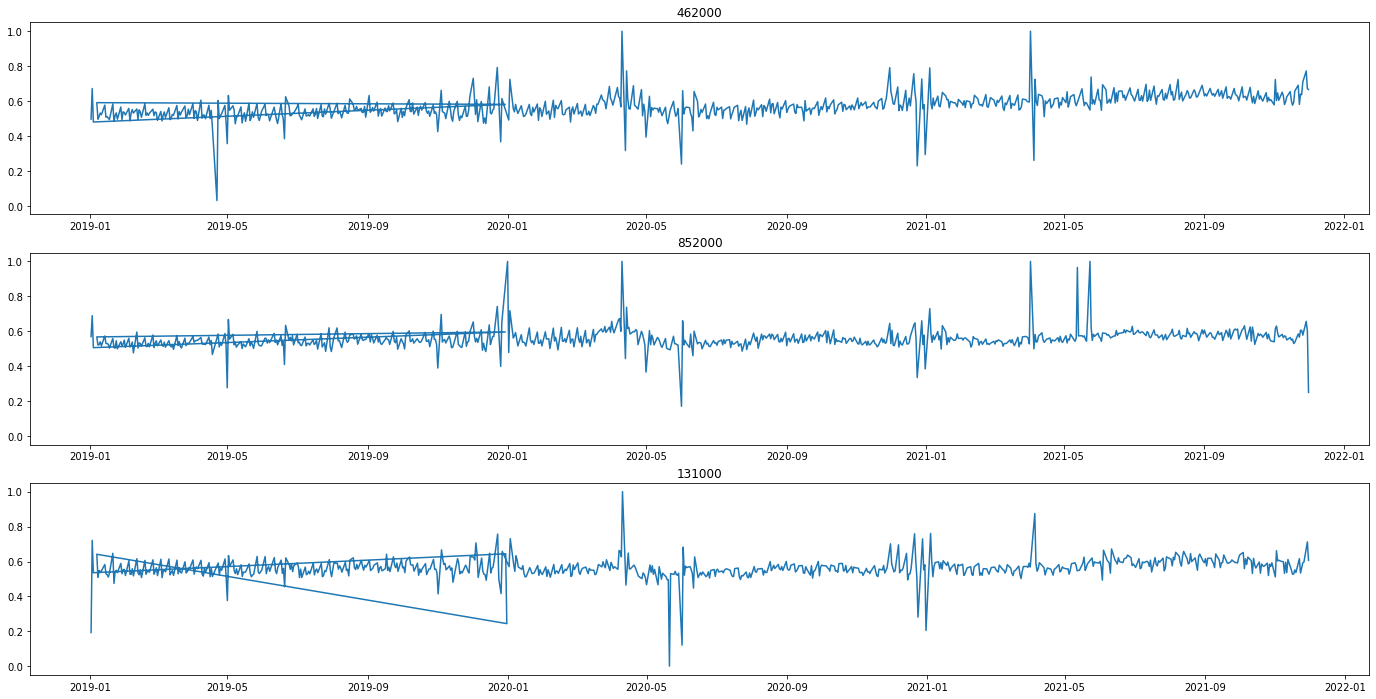

In [22]:
# Entwicklung des PRI-Anteils der grössten drei Standorte
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharey=True, figsize=(24,12))
ax1.plot(df[(df['PZ_plzzz']=='462000')].Datum, df[(df['PZ_plzzz']=='462000')].Anteil_PRI)
ax1.set_title('462000')
ax2.plot(df[(df['PZ_plzzz']=='852000')].Datum, df[(df['PZ_plzzz']=='852000')].Anteil_PRI)
ax2.set_title('852000')
ax3.plot(df[(df['PZ_plzzz']=='131000')].Datum, df[(df['PZ_plzzz']=='131000')].Anteil_PRI)
ax3.set_title('131000')
plt.show()

?

### Delete columns 

<AxesSubplot:>

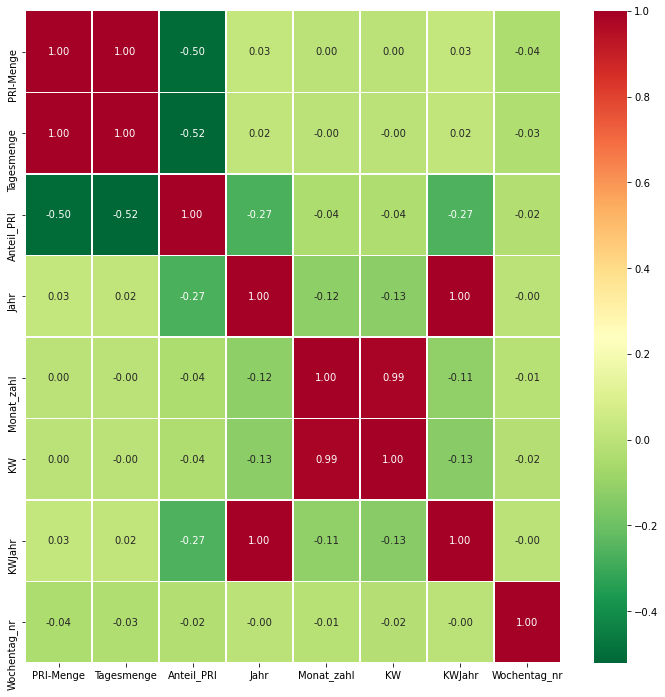

In [23]:
# Plot correlations
plt.subplots(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn_r',linewidth=0.5,fmt='.2f')

In [24]:
# KWJahr ist nicht nötiig, da die Daten auf Tageslevel betrachtet werden
df.drop(['KWJahr', 'PRI-Menge', 'Monat_zahl'], axis=1, inplace=True)

<AxesSubplot:>

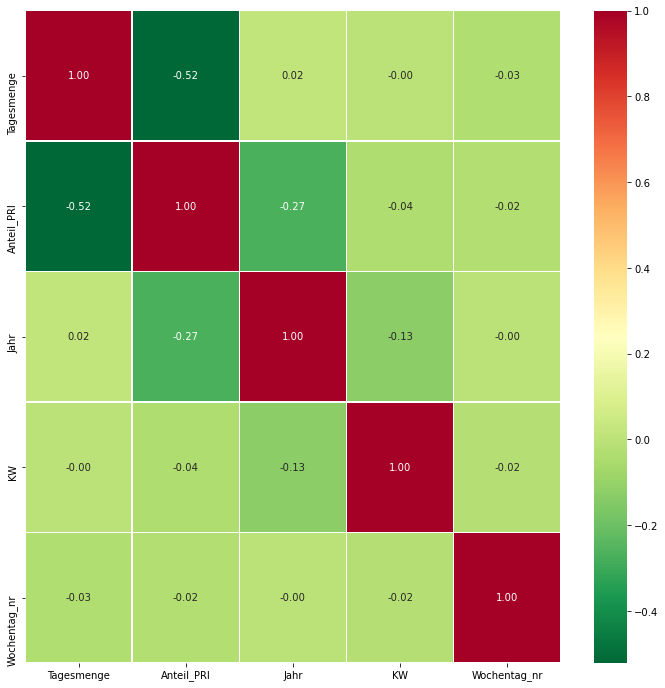

In [25]:
# Plot correlations
plt.subplots(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn_r',linewidth=0.5,fmt='.2f')

### ADD HOLIDAYS 

Feiertage können einen Einfluss auf die Wochentagsverteilung und somit auf den PRI-Anteil haben.

In [26]:
ch_holidays = dict(holidays.Switzerland(years=[2019,2020,2021]).items())
de_holidays = dict(holidays.Germany(years=[2019,2020,2021]).items())
de_holidays_shortend = {key:value for key,value in de_holidays.items() if key not in ch_holidays}
holidays = {**ch_holidays, **de_holidays_shortend}
df['holiday'] = df['Datum'].map(holidays)

## Split Data into Training and Test Data

In [27]:
# Take values from 2021 as test_size and previous years as train_set
test_size = df[df['PZ_plzzz']=='462000'].groupby(['Jahr'])['Datum'].count()[2021]

In [28]:
y=df[df['PZ_plzzz']=='462000'].Anteil_PRI
y=list(y)
y

[0.49648161506528,
 0.671841168483247,
 0.4801444255096982,
 0.5810959266544731,
 0.5909420920460479,
 0.4961393732521796,
 0.512077952278051,
 0.5314297897155972,
 0.5217935880246432,
 0.5769542273250543,
 0.5078895409119989,
 0.5110932779456193,
 0.5023003945680037,
 0.494494978562258,
 0.5825059326809369,
 0.485121469745909,
 0.5173664175597062,
 0.5319522076451034,
 0.4963117459323729,
 0.5659016639747587,
 0.4938989249695223,
 0.5383625104539603,
 0.5350593742104494,
 0.5205934787622314,
 0.5581000848176421,
 0.4871648227209946,
 0.5315906954507719,
 0.5513999408524131,
 0.5312974195823313,
 0.5549251780904875,
 0.4955520859809012,
 0.5495826892317391,
 0.5378296868623287,
 0.5073254886764191,
 0.5843839163760589,
 0.5186789091407428,
 0.5313730500127753,
 0.5182663251893709,
 0.5305930994828962,
 0.5536664944669513,
 0.5163831643223203,
 0.5378610256074399,
 0.533385098432806,
 0.4897536551029599,
 0.5404779692464309,
 0.4865395176422131,
 0.5193473072026102,
 0.5376348926646687,

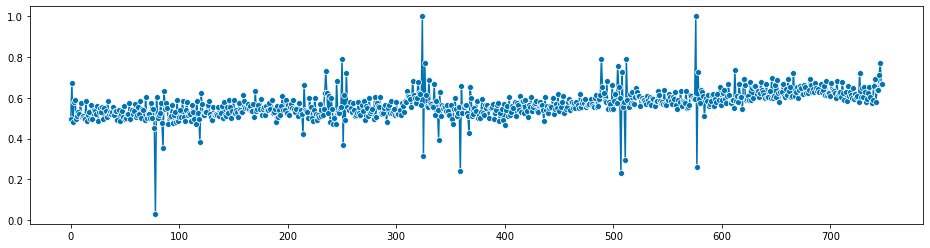

In [29]:
from sktime.utils.plotting import plot_series
y=pd.Series(y)
fig, ax = plot_series(y)

512 237


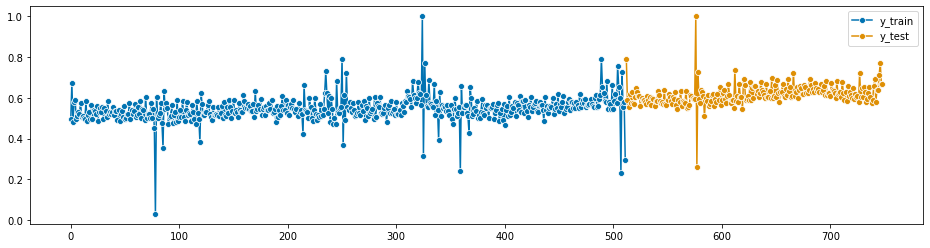

In [30]:
y_train,y_test = temporal_train_test_split(y,test_size=test_size)
plot_series(y_train,y_test,labels =[ "y_train","y_test"])
print(y_train.shape[0],y_test.shape[0])

In [31]:
fh = np.arange(1,len(y_test)+1)

Let's start with two naïve forecasting strategies which can serve as references for comparison of more sophisticated approaches.

We always predict the last value observed (in the training series),
We predict the last value observed in the same season.

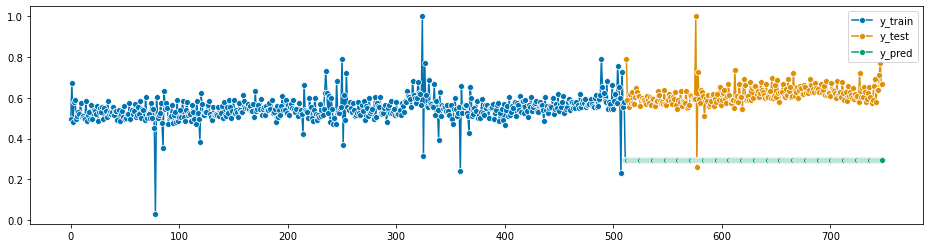

In [32]:
# we can do that with a few lines of code
y_pred = np.repeat(y_train.iloc[-1], len(fh))
y_pred = pd.Series(y_pred, index=y_train.index[-1] + fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

11.02379467900275

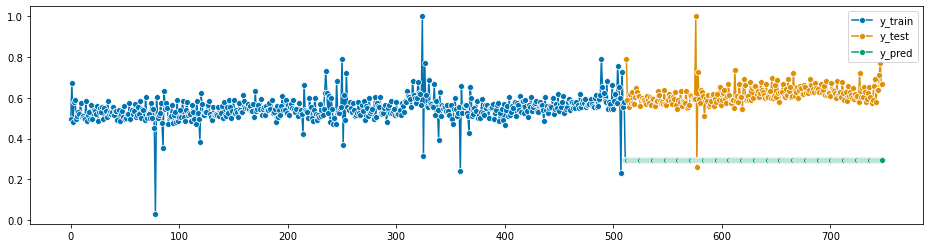

In [33]:
# using sktime 
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import relative_loss

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
y_pred_benchmark = y_pred*1.1
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
relative_loss(y_pred, y_test, y_pred_benchmark=y_pred_benchmark)

0.3168861268739584

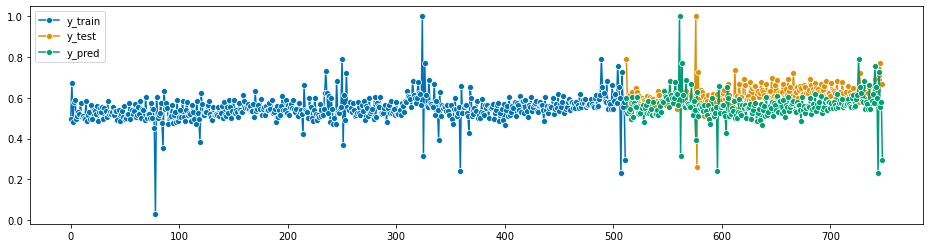

In [34]:
forecaster = NaiveForecaster(strategy="last", sp=test_size)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
relative_loss(y_pred, y_test,y_pred_benchmark=y_pred_benchmark)

## Forecasting with sktime

### Reduction: from forecasting to regression

In [35]:
y_train,y_test = temporal_train_test_split(y,test_size=test_size)

In [36]:
from sktime.forecasting.compose import ReducedRegressionForecaster 
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = RegressionForecaster(regressor=regressor, window_length=12, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
relative_loss(y_test, y_pred)

ImportError: cannot import name 'ReducedRegressionForecaster' from 'sktime.forecasting.compose' (C:\Users\Besitzer\AppData\Roaming\Python\Python38\site-packages\sktime\forecasting\compose\__init__.py)

#### Statistical forecasters 

Exponential Smoothing 

0.20348048904488503

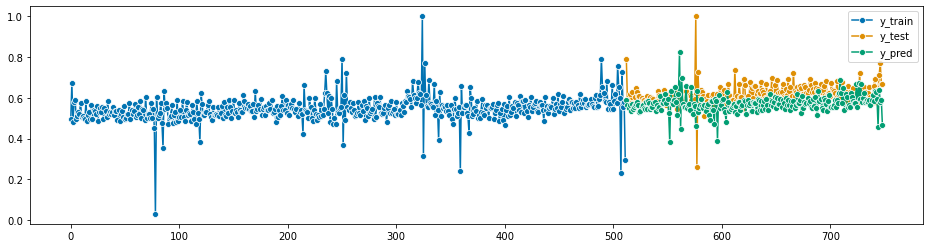

In [37]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=test_size)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
relative_loss(y_test, y_pred, y_pred_benchmark=y_pred_benchmark)

ARIMA

In [38]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=test_size, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
relative_loss(y_test, y_pred,  y_pred_benchmark=y_pred_benchmark)

KeyboardInterrupt: 

Ensemble

In [ ]:
help(EnsembleForecaster)

In [ ]:
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
forecaster = EnsembleForecaster([
    ("ses", ExponentialSmoothing(seasonal="mul", sp=test_size)),
    ("holt", ExponentialSmoothing(trend="mul",  seasonal="mul", sp=test_size)),
    ("damped", ExponentialSmoothing(trend="mul", seasonal="mul", sp=test_size))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
relative_loss(y_test, y_pred, y_pred_benchmark=y_pred_benchmark)

## Time series classification with sktime

### Time series forest 

In [48]:
from sktime.transformers.series_as_features.summarize import RandomIntervalFeatureExtractor

ModuleNotFoundError: No module named 'sktime.transformers'

## Normalization
- Min-Max Normalization
- Z-Score Normalization

In [ ]:
scaler = MinMaxScaler()
x_train_transform = scaler.fit_transform(X_train)
#x_car0_transform = scaler.transform([x_car0])